In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Preprocessing.ipynb
## Preprocessed Text Classification Dataset

In [6]:
%cd drive/MyDrive/Neuromatch

/content/drive/MyDrive/Neuromatch


In [7]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import re

In [8]:
true_data = pd.read_csv('datasets/True.csv')
fake_data = pd.read_csv('datasets/Fake.csv')
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
# Adding labels
true_data["label"] = np.ones(len(true_data),dtype=int)
fake_data["label"] = np.zeros(len(fake_data),dtype=int)

true_data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [10]:
data = pd.concat((true_data,fake_data),axis=0)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB
None


In [11]:
data = data.sample(frac=1)
data.head(10)

,title,text,subject,date,label
16664,"Tillerson urges Iraq, Kurds to resolve conflic...",BAGHDAD (Reuters) - U.S. Secretary of State Re...,worldnews,"October 23, 2017",1
2031,"Congress will raise debt ceiling, has many opt...",WASHINGTON (Reuters) - The U.S. Congress will ...,politicsNews,"August 24, 2017",1
9441,Obama confident Pacific trade deal will be app...,HANOI (Reuters) - U.S. President Barack Obama ...,politicsNews,"May 23, 2016",1
5672,WATCH: The NRA Just Got Caught Desecrating A ...,The NRA claims to care about our military vete...,News,"June 29, 2016",0
13072,WOW! MSNBC’s Senior Political Analyst Hammers ...,Say what??? When former Clinton cheerleader Ma...,politics,"Sep 7, 2016",0
20845,NATO urges trading partners to step up pressur...,BRUSSELS (Reuters) - NATO urged all countries ...,worldnews,"September 6, 2017",1
16307,Czech election winner Babis warms to minority ...,PRAGUE (Reuters) - The anti-establishment ANO ...,worldnews,"October 27, 2017",1
14400,Macron says not in French interests for German...,PARIS (Reuters) - President Emmanuel Macron sa...,worldnews,"November 20, 2017",1
10226,MAJOR LIBERAL RAG RELUCTANTLY PUBLISHES Articl...,"The Atlantic, a publication that wouldn t know...",politics,"Aug 5, 2017",0
5015,Ballet Dancing Great Who Defected From Soviet...,Mikhail Baryshnikov is one of the greatest bal...,News,"August 17, 2016",0


In [12]:
data = data.drop("date",axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 16664 to 19595
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   label    44898 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [ ]:
nltk.download('all')

In [14]:
data.head()

,title,text,subject,label
16664,"Tillerson urges Iraq, Kurds to resolve conflic...",BAGHDAD (Reuters) - U.S. Secretary of State Re...,worldnews,1
2031,"Congress will raise debt ceiling, has many opt...",WASHINGTON (Reuters) - The U.S. Congress will ...,politicsNews,1
9441,Obama confident Pacific trade deal will be app...,HANOI (Reuters) - U.S. President Barack Obama ...,politicsNews,1
5672,WATCH: The NRA Just Got Caught Desecrating A ...,The NRA claims to care about our military vete...,News,0
13072,WOW! MSNBC’s Senior Political Analyst Hammers ...,Say what??? When former Clinton cheerleader Ma...,politics,0


In [15]:
# Tokenize and preprocess text
lemma = WordNetLemmatizer()
pattern = "[^a-zA-Z]"
def preprocess_text(text):
    text = re.sub(pattern, " ", text)  # Cleaning
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    lemmaized_tokens  = [lemma.lemmatize(word) for word in filtered_tokens]
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

    return stemmed_tokens

In [16]:
# Train Word2Vec model
all_tokens = [preprocess_text(text) for text in data['text']] + [preprocess_text(title) for title in data['title']]
model = Word2Vec(all_tokens, vector_size=100, window=5, min_count=1, workers=4)

In [17]:
# Function to vectorize the text
def vectorize_text(text, model):
    vectors = [model.wv[word] for word in text if word in model.wv]
    if not vectors:
        # If none of the words are in the model's vocabulary, return None
        return None
    # Average the word vectors to get the text representation
    avg_vector = sum(vectors) / len(vectors)
    return avg_vector

In [18]:
# Vectorize the "text" column
data['text_vector'] = data['text'].apply(lambda x: vectorize_text(preprocess_text(x), model))

# Vectorize the "title" column
data['title_vector'] = data['title'].apply(lambda x: vectorize_text(preprocess_text(x), model))

# Print the new DataFrame
print(data)

                                                   title  \
16664  Tillerson urges Iraq, Kurds to resolve conflic...   
2031   Congress will raise debt ceiling, has many opt...   
9441   Obama confident Pacific trade deal will be app...   
5672    WATCH: The NRA Just Got Caught Desecrating A ...   
13072  WOW! MSNBC’s Senior Political Analyst Hammers ...   
...                                                  ...   
20155  JUDGE JEANINE IS FURIOUS! “Hillary Won’t Stop ...   
14306  AUSTRIAN Schools Are Being Radicalized By Youn...   
15814  [VIDEO] HILLARY’S VAN BLOWS BY ELDERLY PEOPLE ...   
8952         U.S. lawmakers deadlock on Zika virus funds   
19595  MOCK ASSASSINATION OF DONALD TRUMP Sparks Outr...   

                                                    text       subject  label  \
16664  BAGHDAD (Reuters) - U.S. Secretary of State Re...     worldnews      1   
2031   WASHINGTON (Reuters) - The U.S. Congress will ...  politicsNews      1   
9441   HANOI (Reuters) - U.S. Presid

In [19]:
data.head()

,title,text,subject,label,text_vector,title_vector
16664,"Tillerson urges Iraq, Kurds to resolve conflic...",BAGHDAD (Reuters) - U.S. Secretary of State Re...,worldnews,1,"[-0.20477283, -0.39923164, -0.76950026, 0.4988...","[-1.0021008, -0.728119, -0.7792489, 1.0723425,..."
2031,"Congress will raise debt ceiling, has many opt...",WASHINGTON (Reuters) - The U.S. Congress will ...,politicsNews,1,"[-0.51624465, -1.0285138, -0.2351227, 0.348979...","[-0.78196394, -1.4737996, -0.7698689, 0.193961..."
9441,Obama confident Pacific trade deal will be app...,HANOI (Reuters) - U.S. President Barack Obama ...,politicsNews,1,"[0.11906749, -1.1680127, -0.6019835, 0.1415119...","[-0.24060069, -0.7965209, -0.34325874, -0.5839..."
5672,WATCH: The NRA Just Got Caught Desecrating A ...,The NRA claims to care about our military vete...,News,0,"[0.25936678, -0.6029397, -0.28085747, 0.071327...","[0.5504718, 0.0356774, -0.30024818, -0.2528649..."
13072,WOW! MSNBC’s Senior Political Analyst Hammers ...,Say what??? When former Clinton cheerleader Ma...,politics,0,"[0.14806132, 0.0039087017, 0.011725389, -0.402...","[-0.36672437, 0.4235775, 0.683549, -0.05561705..."


In [20]:
# Drop rows with missing vector representations
data = data.dropna()

In [21]:
# data.to_csv('/content/drive/MyDrive/Neuromatch/ANN/temp/preprocessed_dataset.csv')

# Split the data into training and testing sets

In [22]:
# Prepare input and target data
X_text = np.array(data['text_vector'].tolist())
X_title = np.array(data['title_vector'].tolist())
X_combined = np.hstack((X_text, X_title))  # Concatenate both vectors
y = np.array(data['label'])

In [23]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Training ANN Model

In [32]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
class ANN(nn.Module):

    def __init__(self):
        super(ANN, self).__init__()
        self.linear1 = nn.Linear(200, 1000)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)  # Add dropout layer

        self.linear2 = nn.Linear(1000, 500)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.linear3 = nn.Linear(500, 100)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)

        self.linear4 = nn.Linear(100, 20)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)

        self.linear5 = nn.Linear(20, 2)


    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.linear2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        out = self.linear3(out)
        out = self.relu3(out)
        out = self.dropout3(out)

        out = self.linear4(out)
        out = self.relu4(out)
        out = self.dropout4(out)

        out = self.linear5(out)

        return out



ann_model = ANN()
optimizer = torch.optim.Adam(ann_model.parameters(), lr=0.01)
error = nn.CrossEntropyLoss()

In [48]:
# Converting numpy arrays into pytorch tensors
X_train = torch.Tensor(X_train)

# You must convert it into LongTensor. I did it once
y_train = torch.Tensor(y_train).type(torch.LongTensor)

X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(y_test)

EPOCHS = 30
l1_weight = 0.0004
l2_weight = 0.0003

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    outs = ann_model(X_train)
    loss = error(outs, y_train)

    # L1 and L2 regularization
    l1_regularization = 0.0
    l2_regularization = 0.0

    for param in ann_model.parameters():
        l1_regularization += torch.norm(param, p=1)
        l2_regularization += torch.norm(param, p=2)**2

    l1 = l1_weight * l1_regularization
    l2 = 0.5 * l2_weight * l2_regularization

    loss += l1
    loss += l2

    loss.backward()
    optimizer.step()

    print(f"Loss after iteration {epoch} is {loss}")


Loss after iteration 0 is 7.289565563201904
Loss after iteration 1 is 5.031970500946045
Loss after iteration 2 is 3.543056011199951
Loss after iteration 3 is 2.939337968826294
Loss after iteration 4 is 2.8936123847961426
Loss after iteration 5 is 2.6674869060516357
Loss after iteration 6 is 2.3943393230438232
Loss after iteration 7 is 2.2335290908813477
Loss after iteration 8 is 2.123493194580078
Loss after iteration 9 is 2.100046396255493
Loss after iteration 10 is 2.054633855819702
Loss after iteration 11 is 1.9123637676239014
Loss after iteration 12 is 1.7401039600372314
Loss after iteration 13 is 1.6494910717010498
Loss after iteration 14 is 1.560207486152649
Loss after iteration 15 is 1.4513250589370728
Loss after iteration 16 is 1.4387356042861938
Loss after iteration 17 is 1.353416085243225
Loss after iteration 18 is 1.289966106414795
Loss after iteration 19 is 1.228777289390564
Loss after iteration 20 is 1.1659948825836182
Loss after iteration 21 is 1.1524158716201782
Loss afte

In [49]:
# Importing metrics
from sklearn.metrics import accuracy_score,confusion_matrix


# Prediction
y_head = ann_model(X_test)
print(y_head[0])
# Converting Prediction into labels
y_pred = torch.max(y_head,1)[1]
print(y_pred[0])

# Accuracy score
print("Model accuracy is ",accuracy_score(y_pred,y_test))

tensor([ 7.0391, -7.7056], grad_fn=<SelectBackward0>)
tensor(0)
Model accuracy is  0.9553873955274452


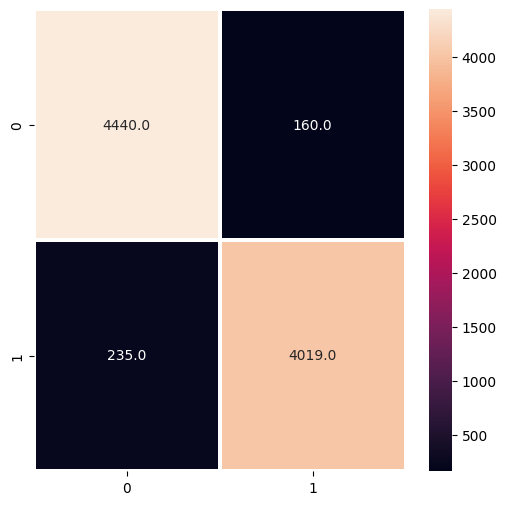

In [50]:
confusion_matrix = confusion_matrix(y_pred=y_pred,y_true=y_test)

fig,ax = plt.subplots(figsize=(6,6))
sns.heatmap(confusion_matrix,annot=True,fmt="0.1f",linewidths=1.5)
plt.show()